In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [8]:
ticker_list = ["SPY"]

In [9]:
def load_data(symbol):
    
    data = pd.read_csv(f"./data/{symbol}.csv")
    
    return data

In [10]:
def compute_returns(data):
    
    data = 100*(data-data[0])/data[0]
    
    return data

In [11]:
def compute_change(current_price, purchase_price_array):
    
    data = 100*(current_price-purchase_price_array)/purchase_price_array
    
    return data

In [12]:
data_list = []

for ticker in ticker_list:
    data = load_data(ticker)["Close"]
    if ticker != "VIX":
        data = compute_returns(data)
    data_list.append(data)
    

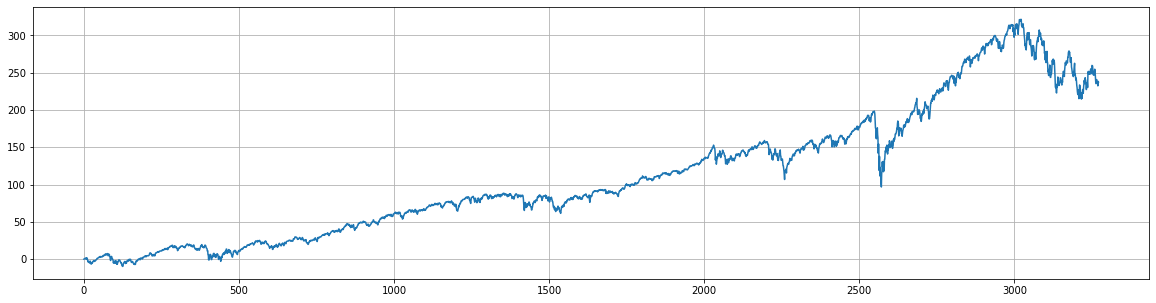

In [13]:
plt.figure(figsize=(20, 5))
plt.grid()

for price in data_list:
    plt.plot(price)
    
plt.show()

In [14]:
data_spy = load_data("SPY")
price = data_spy["Close"].values

In [26]:
# parameters

use_scheme = True

invest_at_bottom = 100
n_years_look_back = 1

In [29]:
def compute_howmuch_to_invest(current_price, period_low, investment_threshold_low, use_scheme):
    
    change_all_time_low = 100*(current_price-period_low)/period_low
    
    x = 100
    if use_scheme:
        x = 0
        if change_all_time_low <= investment_threshold_low:
            x = 100
    
    return x

In [116]:
def compute_returns(n_trading_days_look_back, look_back_years, investment_threshold, use_scheme=True):
    
    # invest every month, which means every 21 trading days per month on average
    n_trading_days_look_back = int(look_back_years*12*21)
    list_amount_and_price = []
    amount_to_invest = 1 # we start with 1 unit to invest (a sum that we can save every month to invest)

    for i in range(1, len(price)):

        until_present_prices = price[:i] # this is to make sure we avoid future leakage
        
        # monthly payment (e.g., salary)
        if (i % 21) == 0:
            amount_to_invest += 1
        
        # invest or not
        if i >= n_trading_days_look_back:

            current_price = until_present_prices[-1]
            period_low_price = np.min(until_present_prices[-n_trading_days_look_back:])
            all_time_high_price = np.max(until_present_prices)

            percentage_to_invest = compute_howmuch_to_invest(current_price, period_low_price, investment_threshold, True)

            amount_invested = amount_to_invest*(percentage_to_invest/100)
            if np.abs(amount_invested - amount_to_invest) < 10e-4:
                amount_invested = amount_to_invest
            else:
                assert amount_invested <= amount_to_invest, f"problemo: amount invested {amount_invested}, amount to invest {amount_to_invest}"

            amount_to_invest -= amount_invested
            list_amount_and_price.append((amount_invested, current_price, amount_to_invest))
    
    investment_list = np.array([val[0] for val in list_amount_and_price])
    price_list = np.array([val[1] for val in list_amount_and_price])

    changes_list = compute_change(price[-1], np.array(price_list))
    changes_list = 1 + changes_list/100

    # this is the number we are interested in optimising
    total_investable_capital = (len(price) // 21) + 1
    invested_capital = np.sum(investment_list)
    non_invested_capital = total_investable_capital-invested_capital
    
    invested_capital_present_value = np.sum(investment_list*changes_list)
    # we assume that the capital not invested as 0 appreciation over time
    total_capital_present_value = invested_capital_present_value + non_invested_capital

    returns = 100*(total_capital_present_value-total_investable_capital)/total_investable_capital

    
    return returns, list_amount_and_price

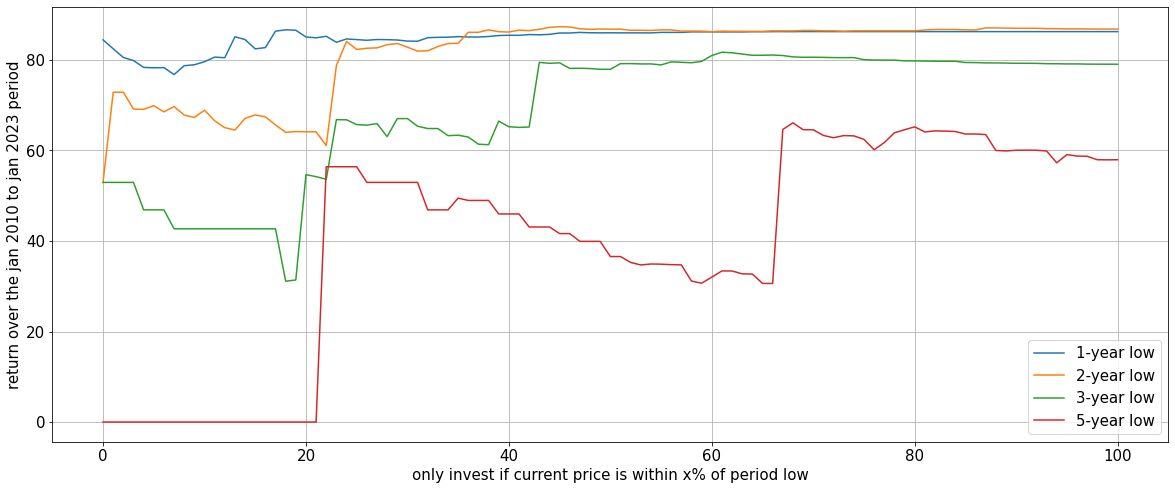

In [125]:
plt.figure(figsize=(20, 8))
plt.grid()
plt.xlabel("only invest if current price is within x% of period low", size=15)
plt.ylabel("return over the jan 2010 to jan 2023 period",  size=15)
plt.xticks(size=15)
plt.yticks(size=15)

for look_back_years in [1, 2, 3, 5]:
    
    returns_list = []
    
    for inv_low in np.arange(0, 101, 1):

        returns, list_amount_and_price = compute_returns(n_trading_days_look_back, look_back_years, inv_low, use_scheme)
        returns_list.append(returns)
    
    plt.plot(returns_list)  

plt.legend(["1-year low", "2-year low", "3-year low", "5-year low"], fontsize=15)
plt.savefig(f'graph_dca.png', dpi=600, bbox_inches='tight')    
plt.show()

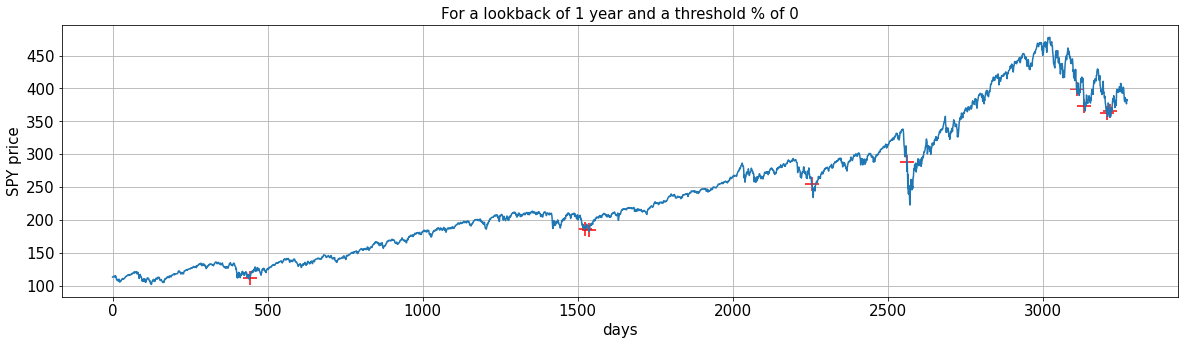

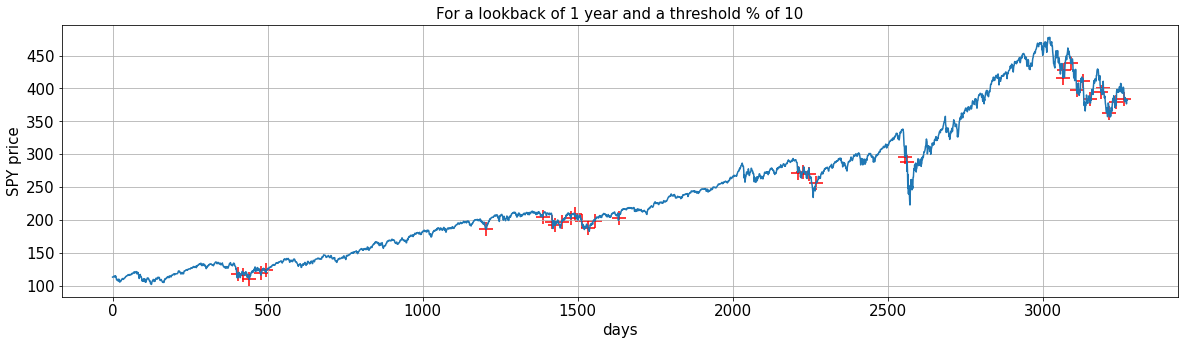

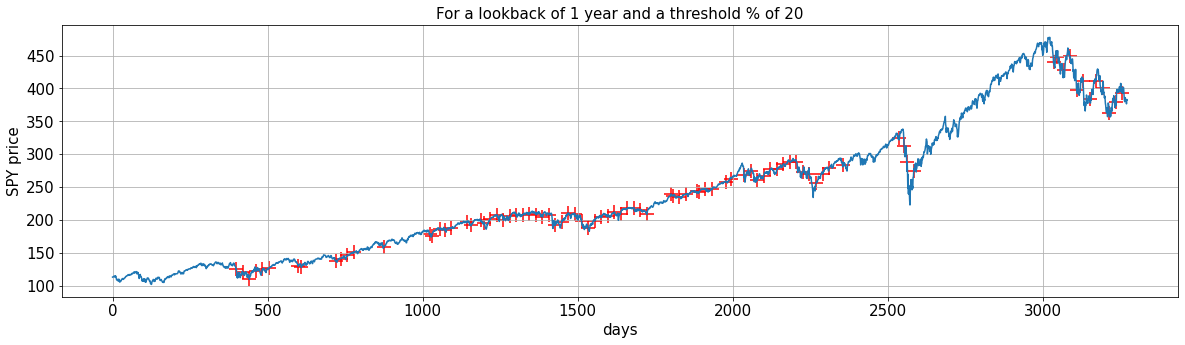

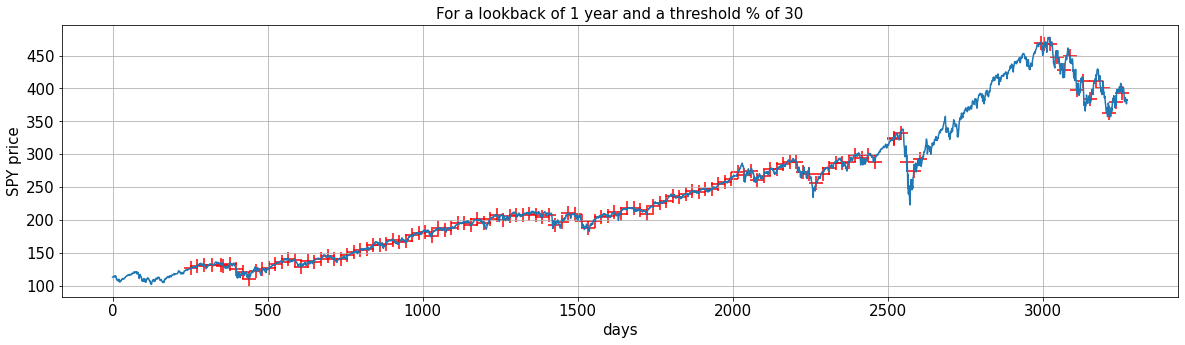

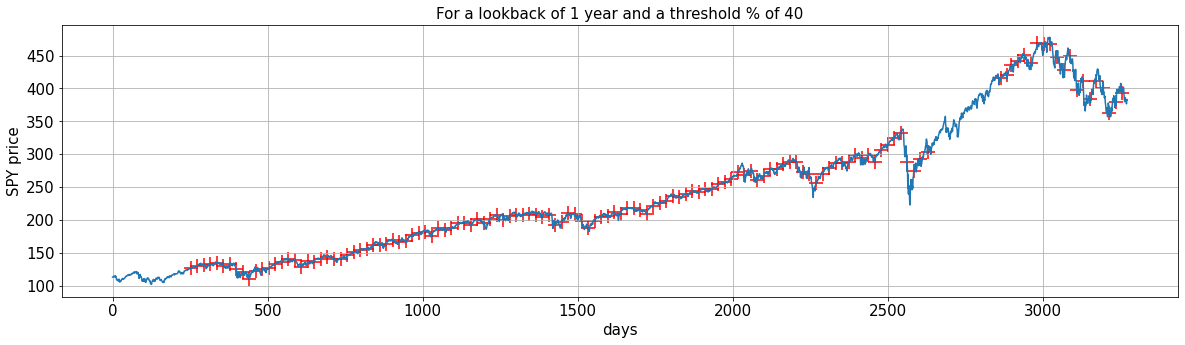

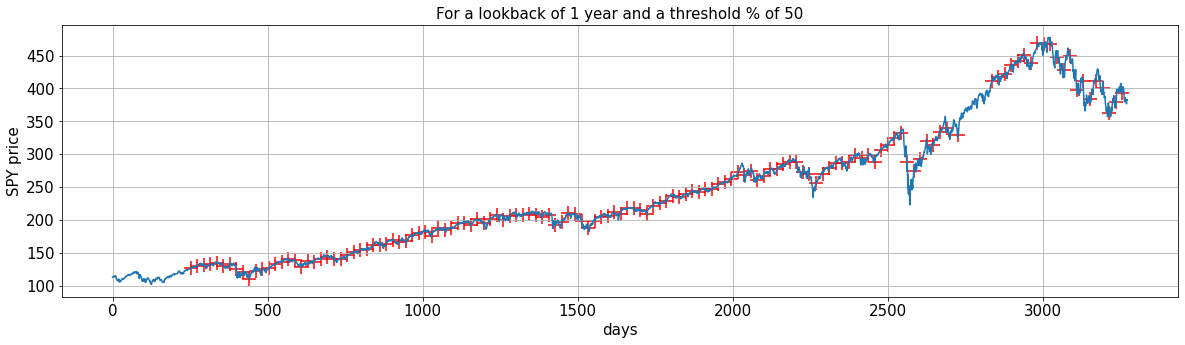

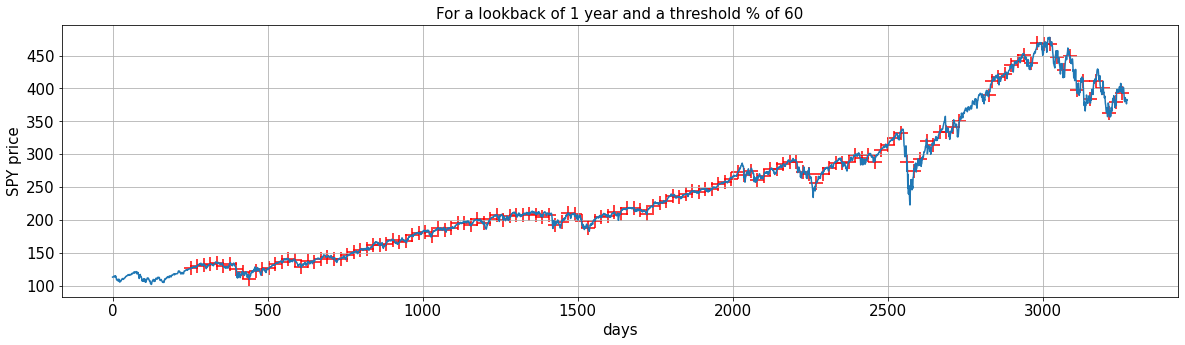

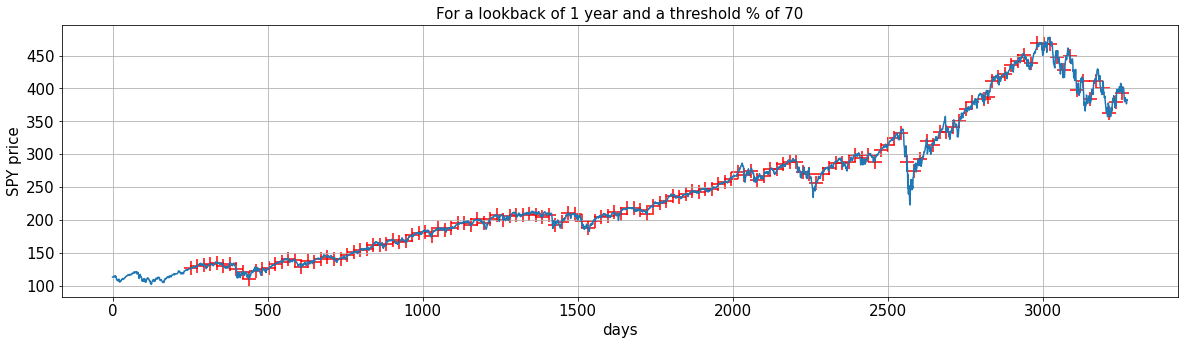

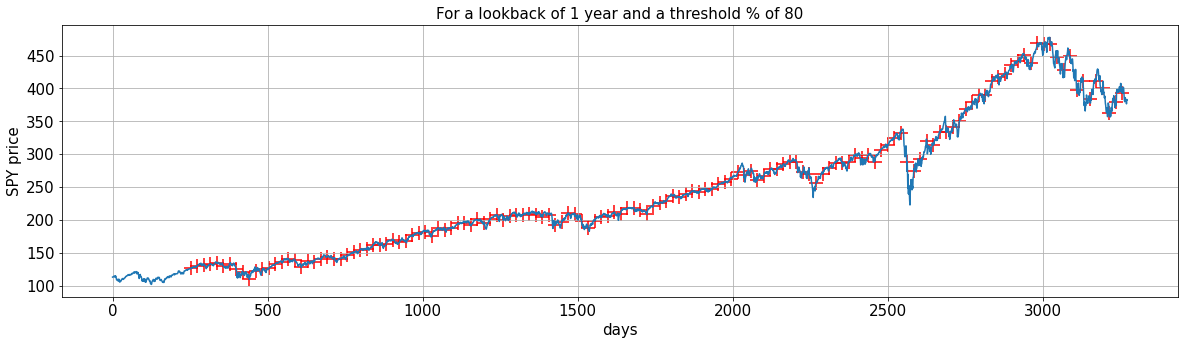

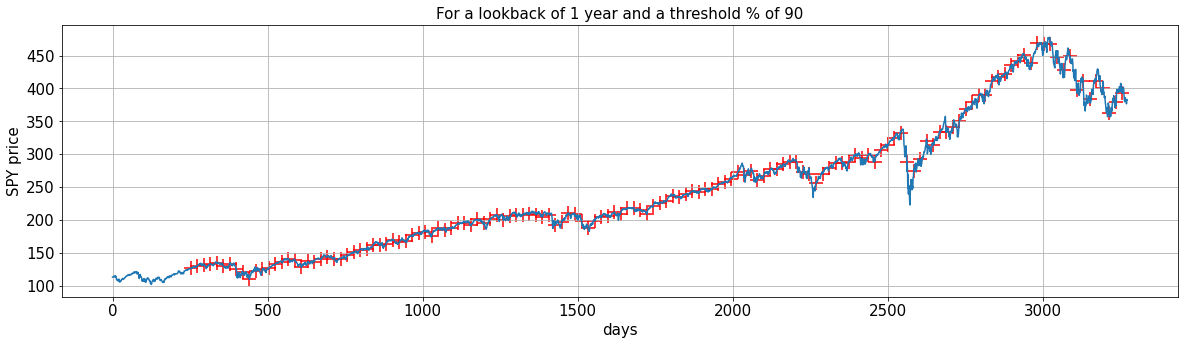

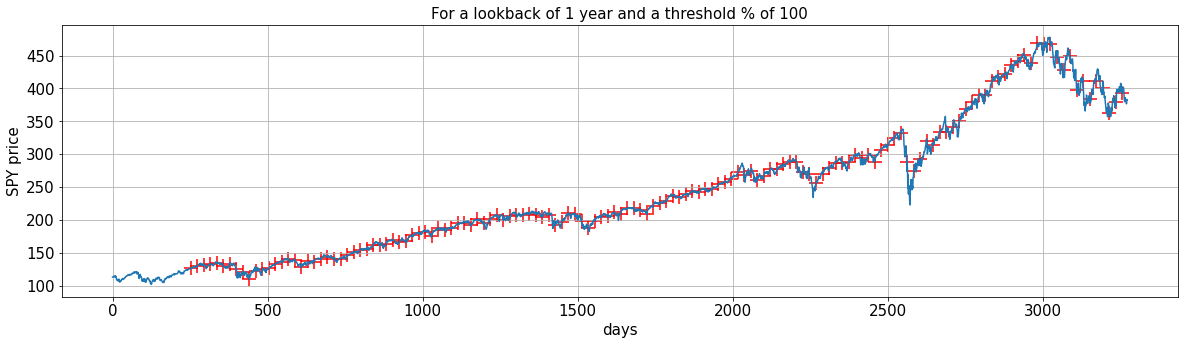

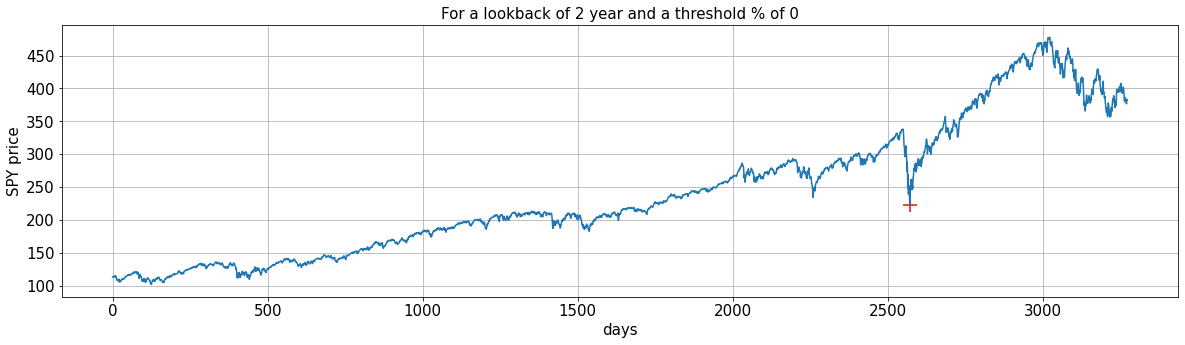

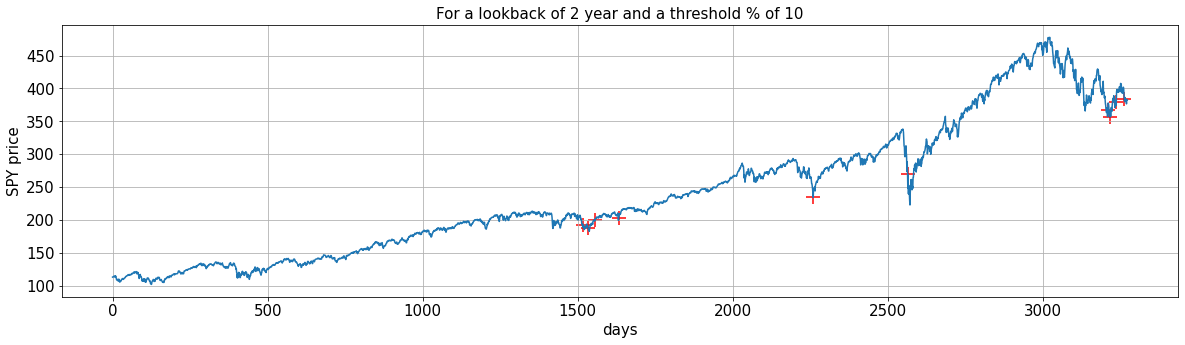

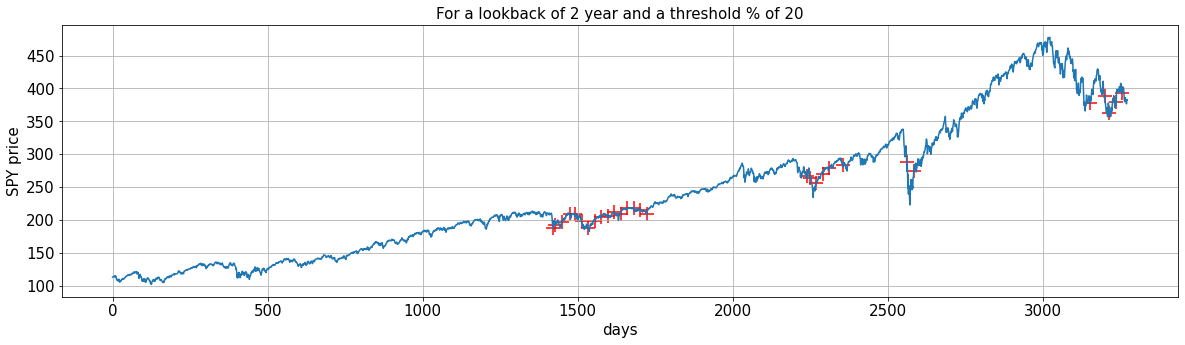

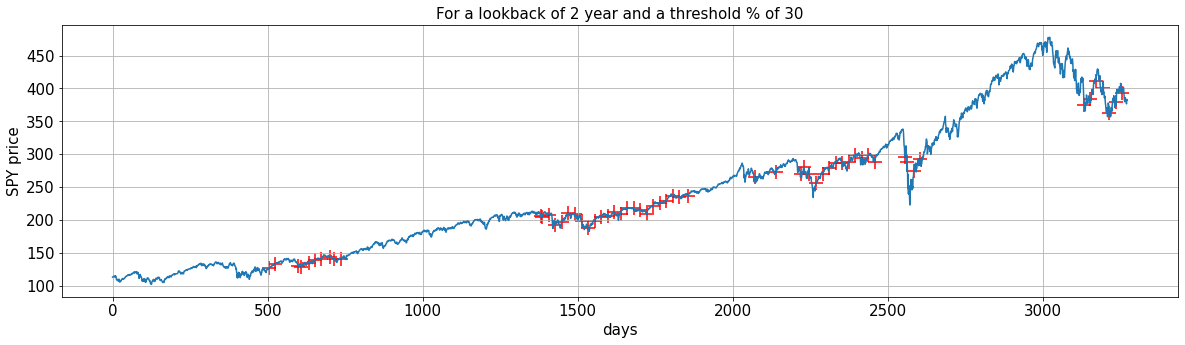

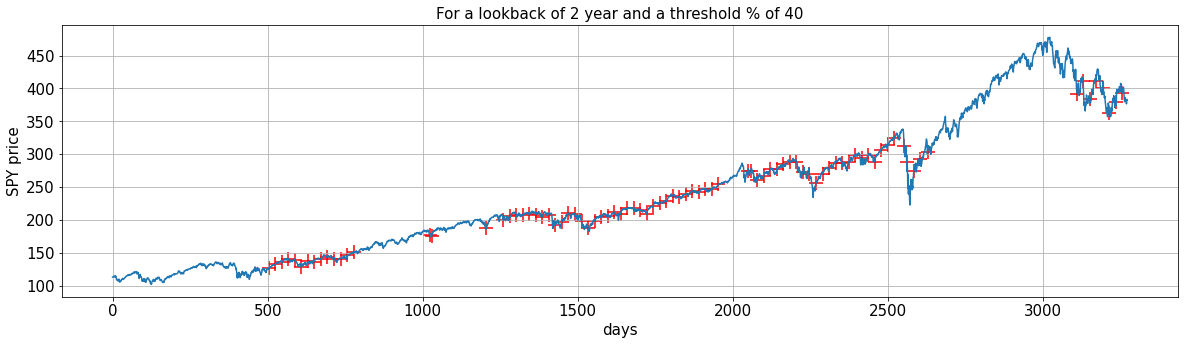

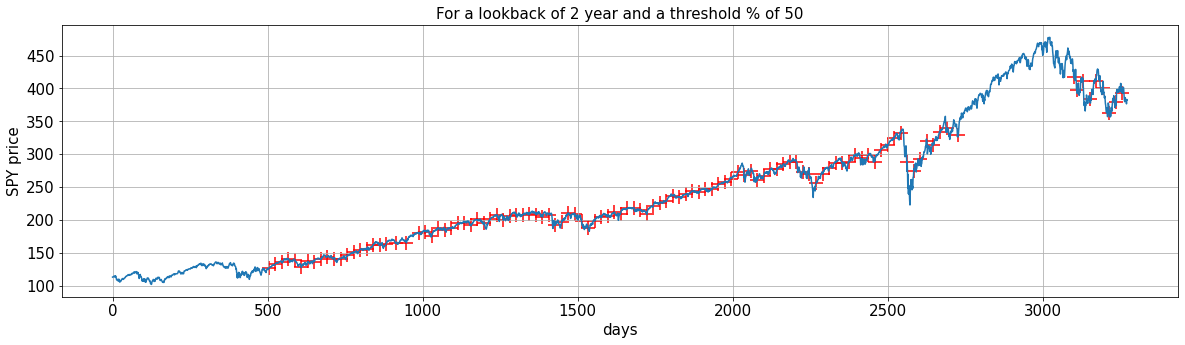

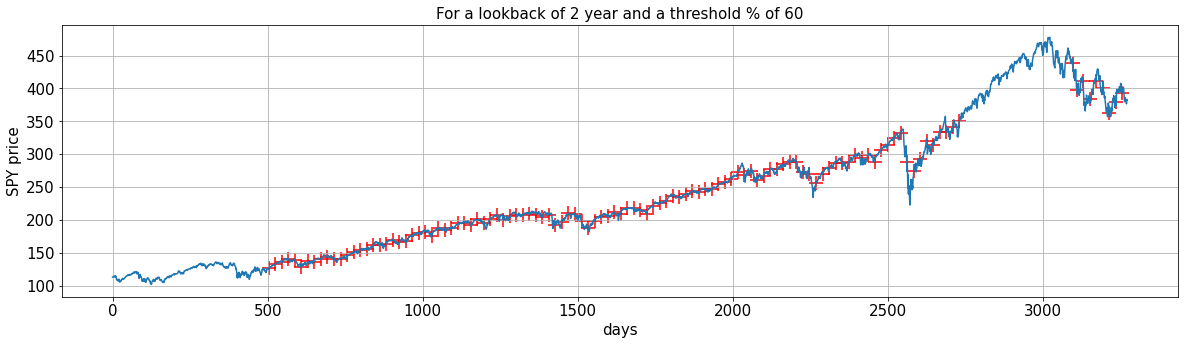

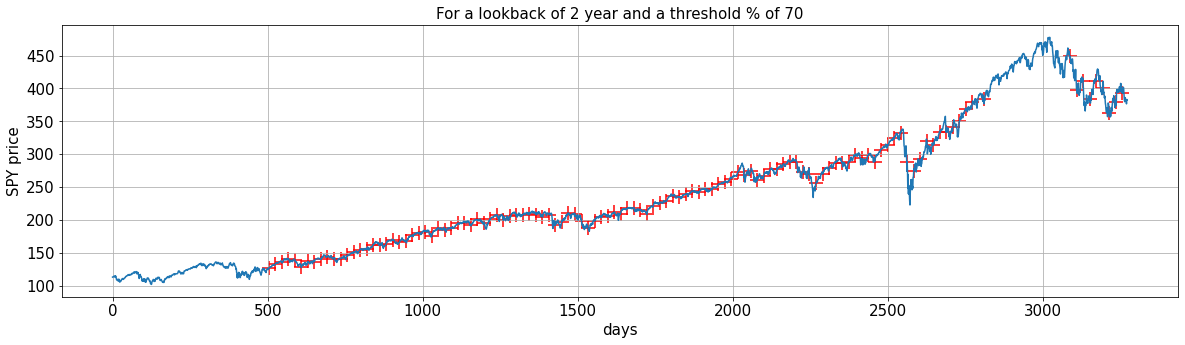

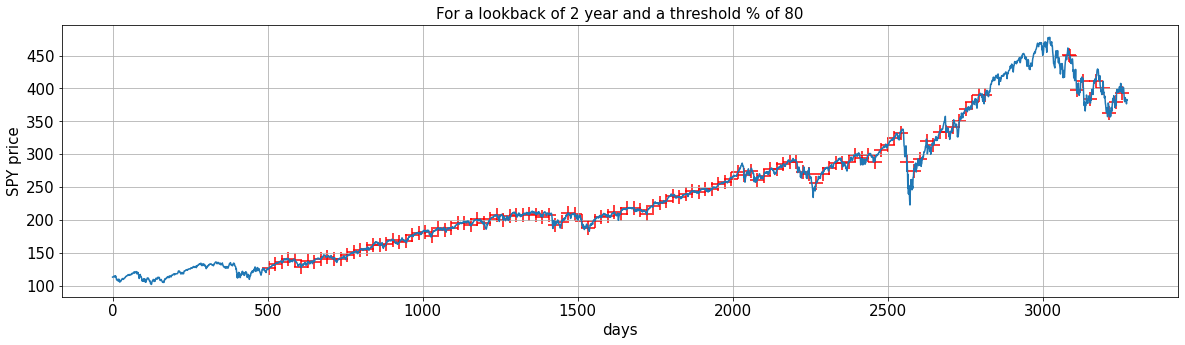

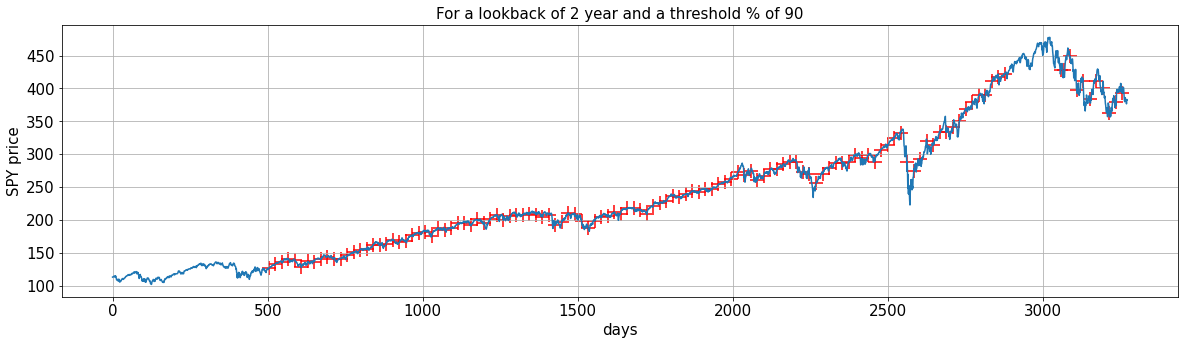

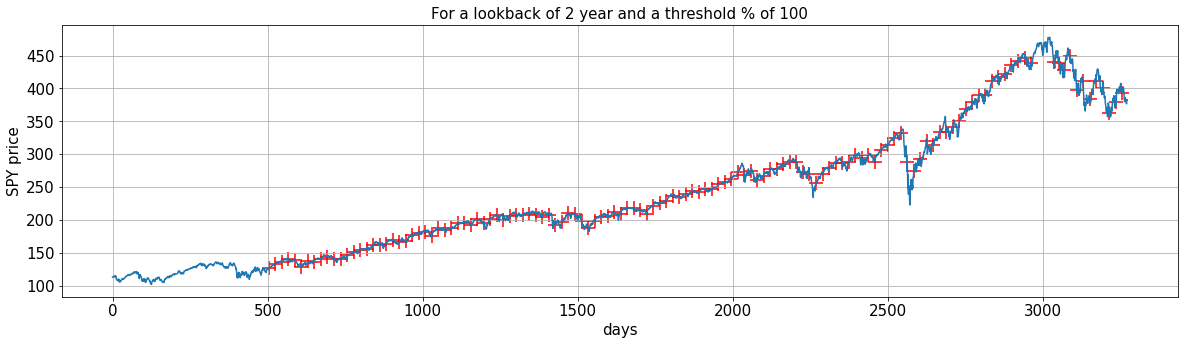

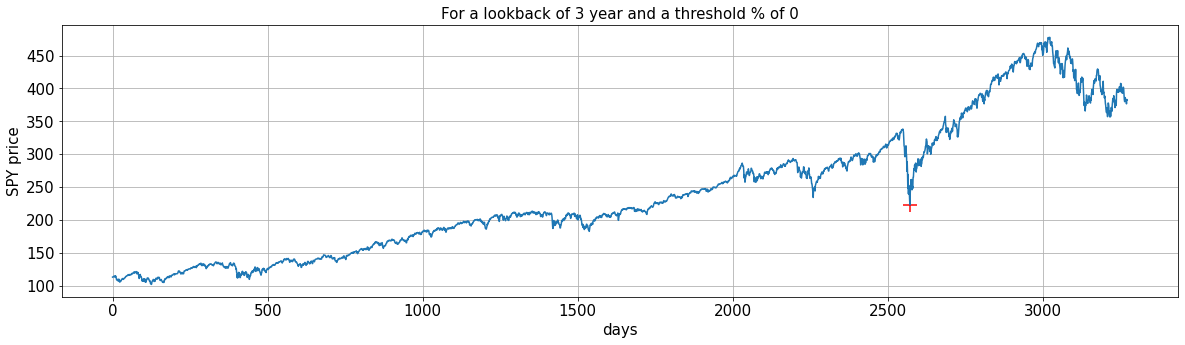

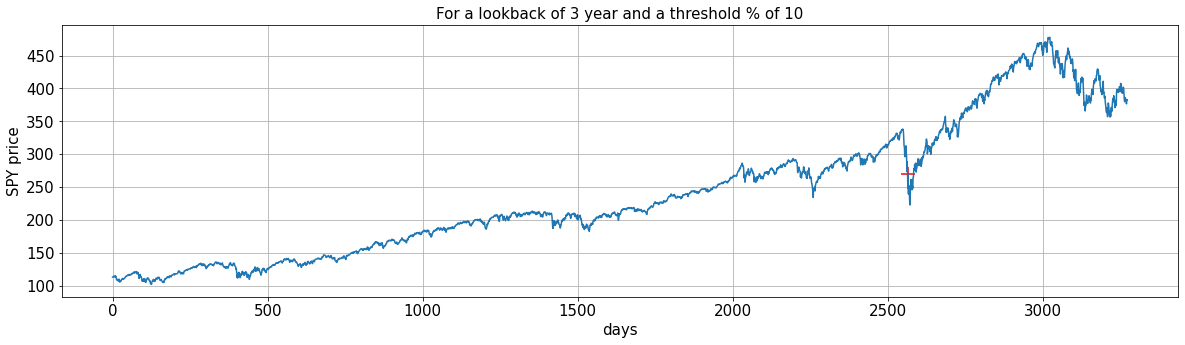

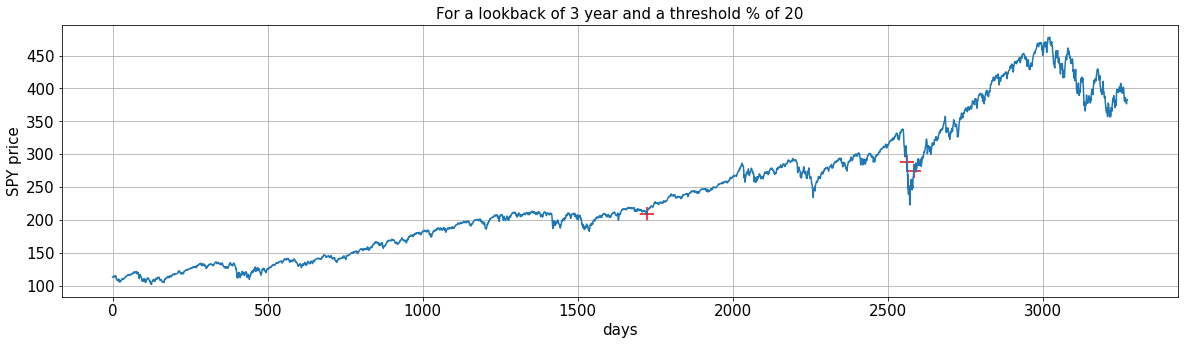

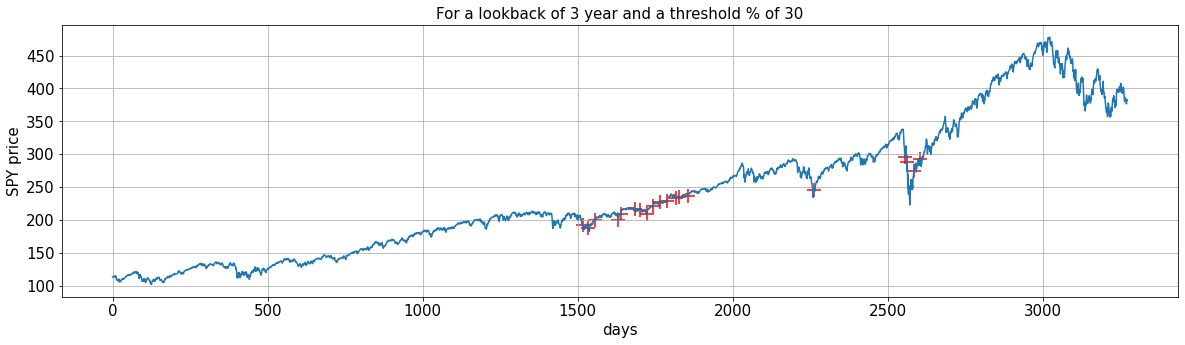

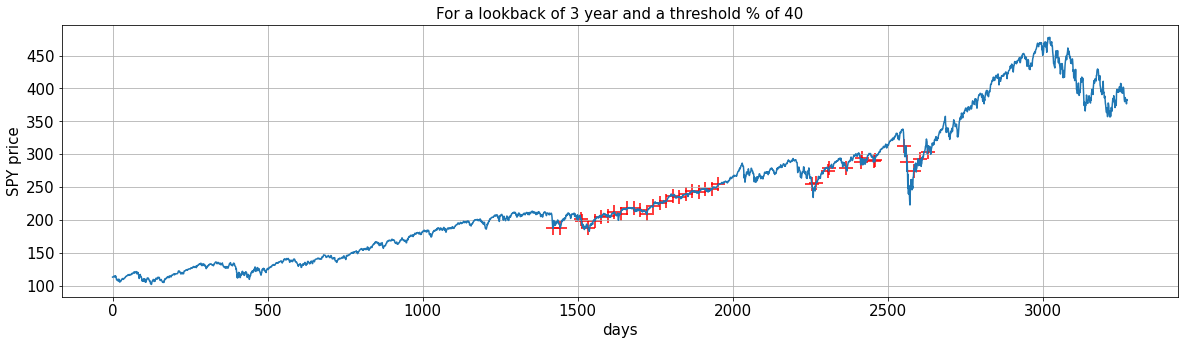

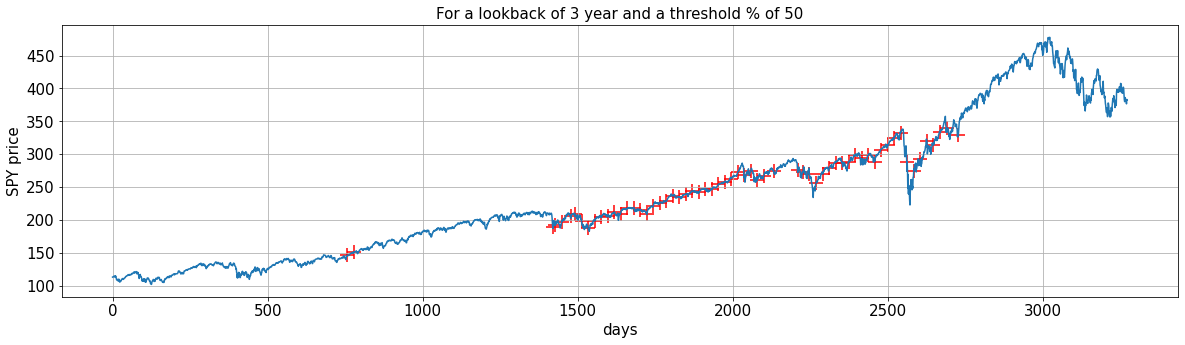

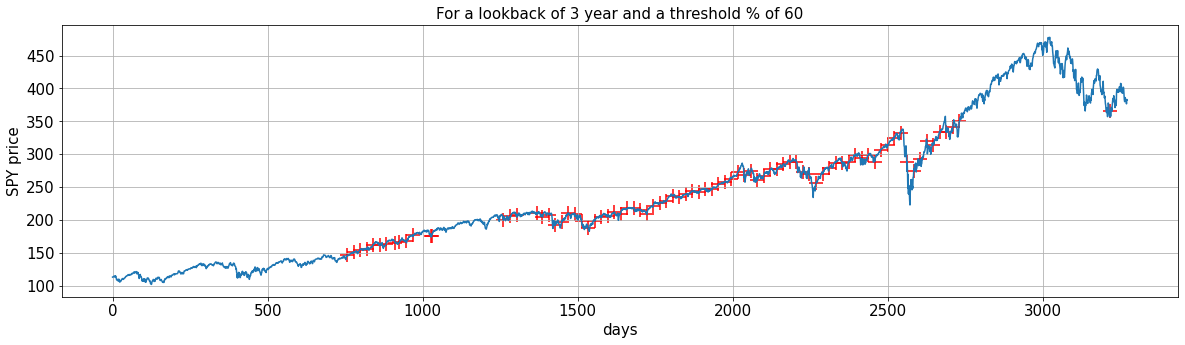

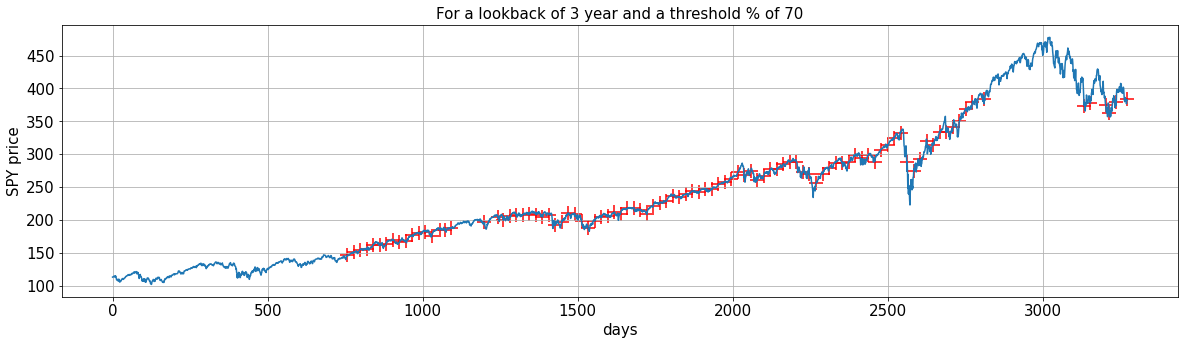

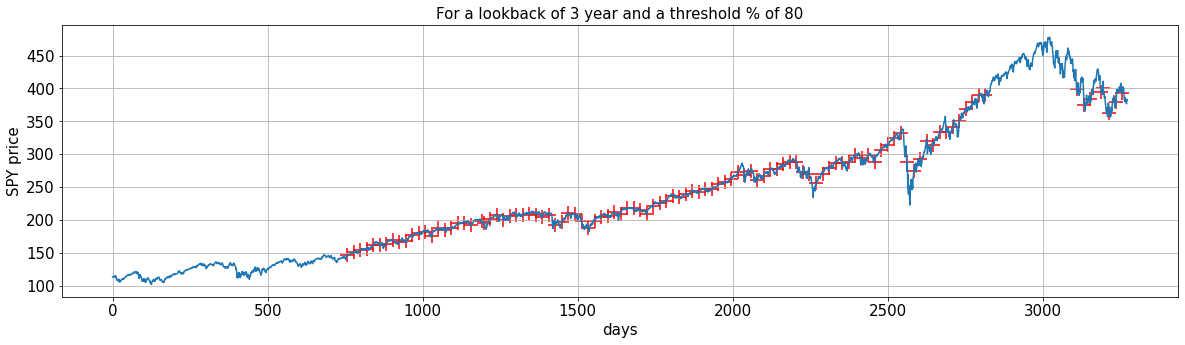

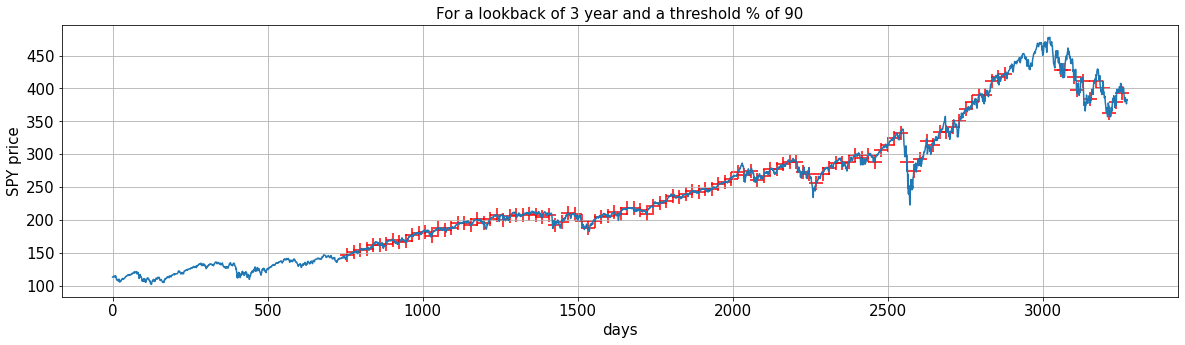

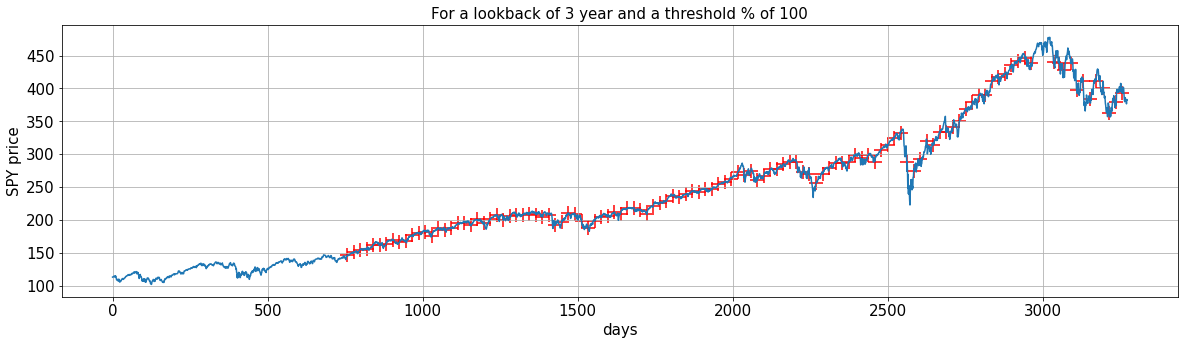

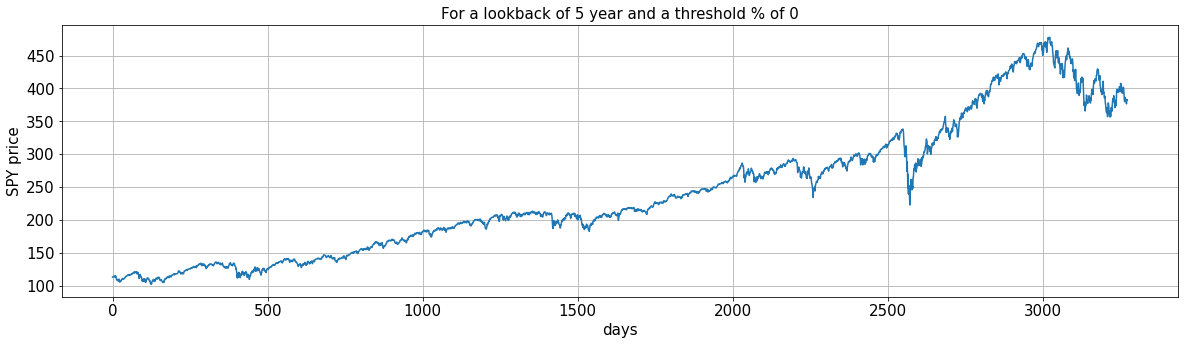

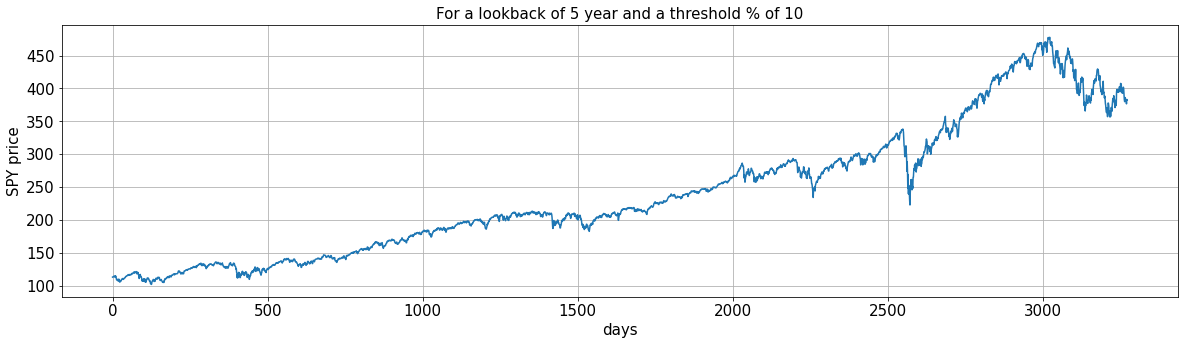

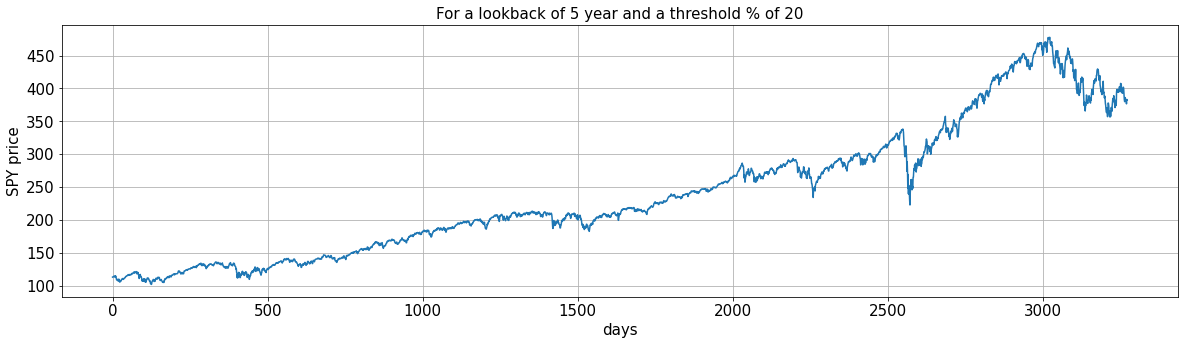

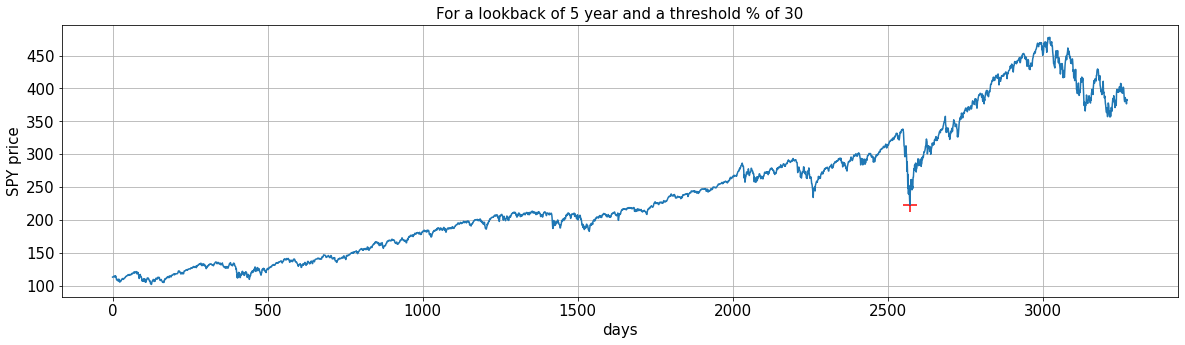

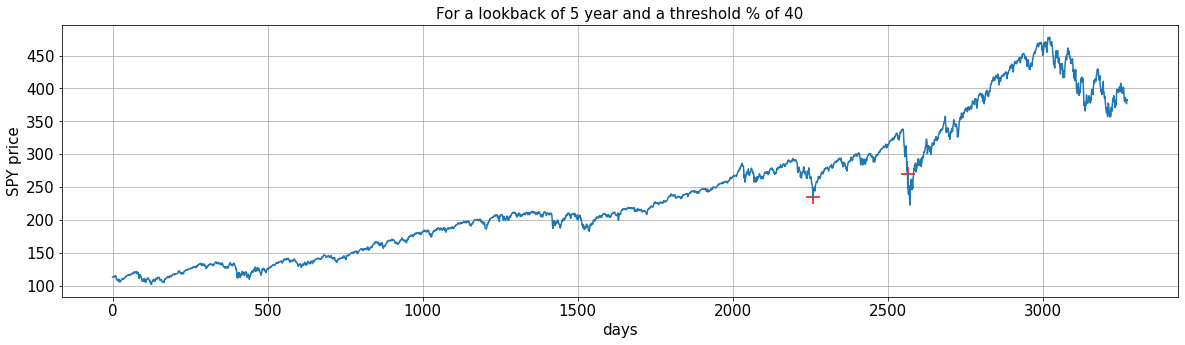

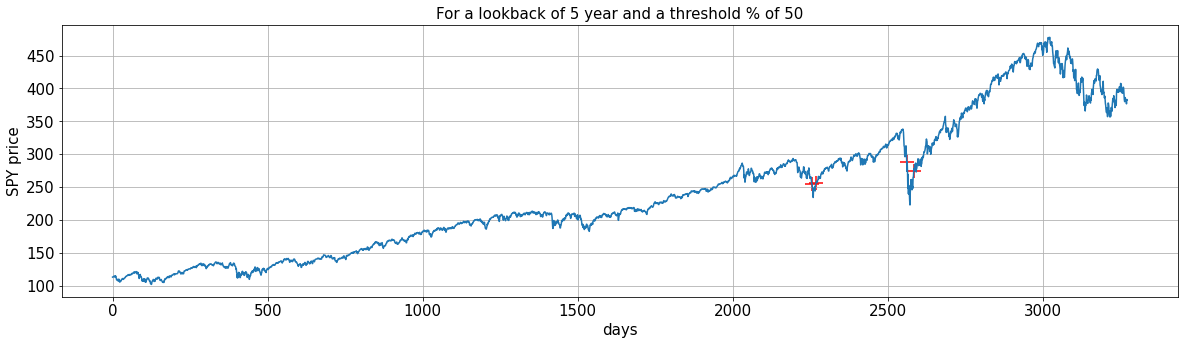

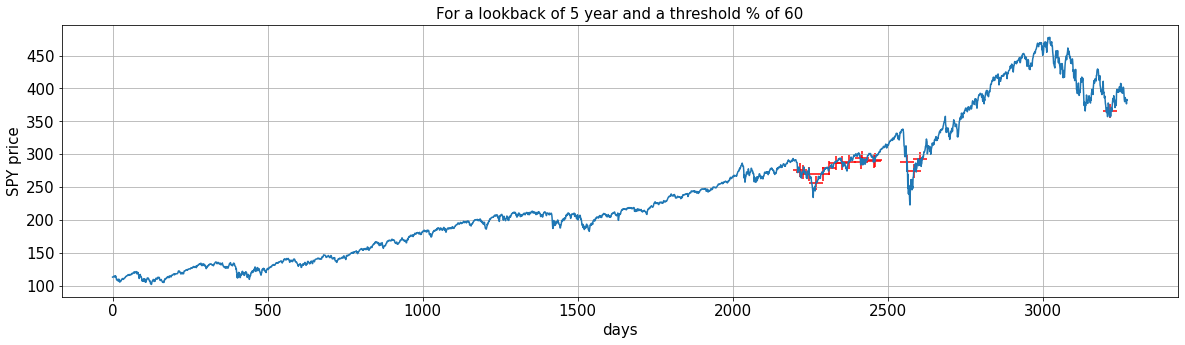

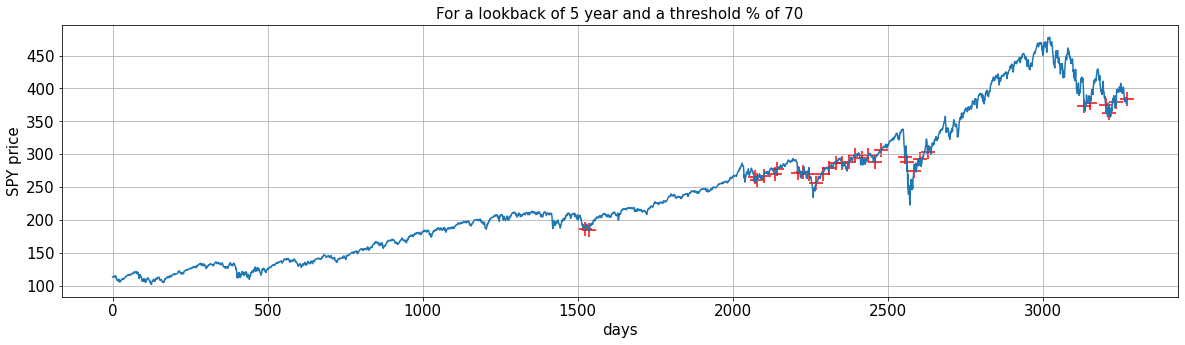

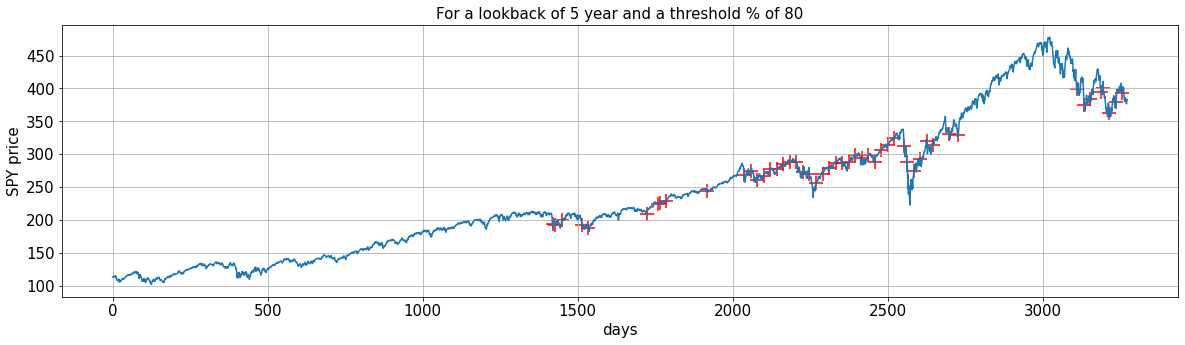

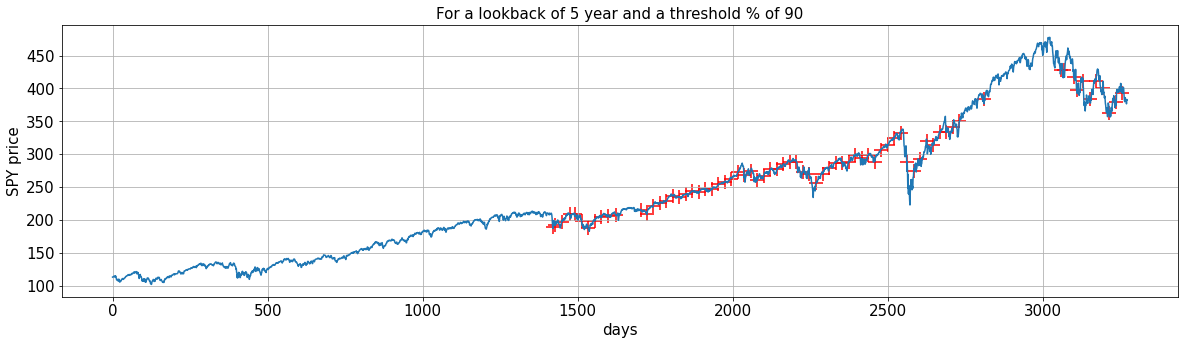

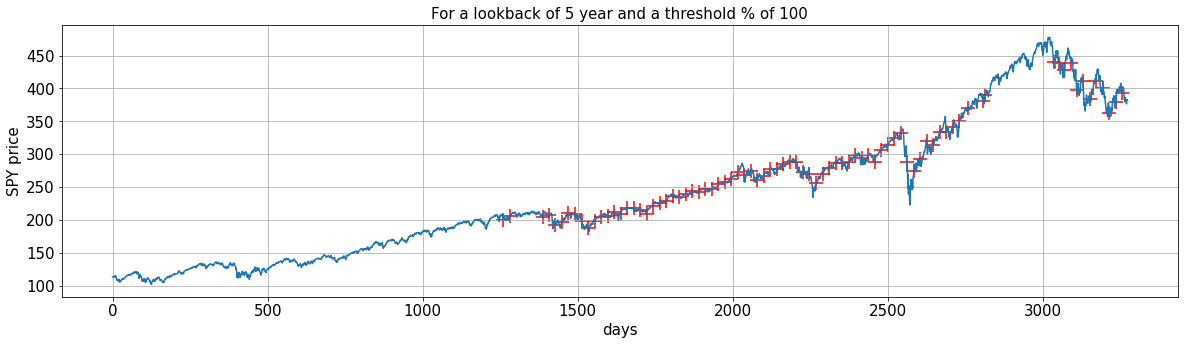

In [136]:
for look_back_years in [1, 2, 3, 5]:
    
    returns_list = []
    
    for inv_low in np.arange(0, 101, 10):

        returns, list_amount_and_price = compute_returns(n_trading_days_look_back, look_back_years, inv_low, use_scheme)
        
        amount_invested = [element[0] for element in list_amount_and_price]
        shift = look_back_years*12*21
        investment_timestamps = shift + np.array([i for i in range(len(amount_invested)) if amount_invested[i] != 0])
        
        plt.figure(figsize=(20, 5))
        plt.title(f"For a lookback of {look_back_years} year and a threshold % of {inv_low}", size=15)
        plt.grid()
        plt.xlabel("days", size=15)
        plt.ylabel("SPY price", size=15)
        plt.yticks(size=15)
        plt.xticks(size=15)
        plt.plot(price)
        try:
            plt.scatter(investment_timestamps, price[investment_timestamps], s = 200, color="red", marker="+")
        except IndexError:
            pass
        plt.savefig(f'{look_back_years}_years_{inv_low}_%.png', dpi=600, bbox_inches='tight')    
        plt.show()